# Pauly's example of 2D RF excitation #
https://www.sciencedirect.com/science/article/abs/pii/S1090780711003351?via%3Dihub
#https://onlinelibrary.wiley.com/doi/epdf/10.1002/mrm.1910240211

In [1]:
%matplotlib inline
import numpy as np
from phantominator import shepp_logan
import scipy.io as sio

# import cv2
import pywt

import matplotlib.pyplot as plt

## k-space trajectories: ##

In [2]:
def k_x(A=1,dt=0.0001,T=1,n=8,db=0):
    '''
    input:
    A = scaling factor [1/cm]
    dt = time resolution [s]
    T = duration [s]
    n = number of lobes
    '''
    t = np.arange(0,T,dt)
    return A * (1 - t/T)  * np.cos((2*np.pi*n*t)/T)

def k_y(A=1,dt=0.0001,T=1,n=8,db=0):
    '''
    input:
    A = scaling factor [1/cm]
    dt = time resolution [s]
    T = duration [s]
    n = number of lobes
    '''
    t = np.arange(0,T,dt)
    return A * (1 - t/T)  * np.sin((2*np.pi*n*t)/T)

In [3]:
# plt.plot(k_x(n=10),k_y(n=10))

## Gradients ##

In [4]:
# derivative of kx : Gx = -1 / gamma * dkx/dt
def G_x(nuc='1h',A=1,dt=0.0001,T=1,n=8,gamma=0,db=0):
    '''
    input:
    nuc: nucleus
    A: Amplitude [1/cm]
    dt: time resolution [s]
    T: duration [s]
    gamma: gyromagnetic ratio [MHz/T]
    '''
    if (gamma==0):
        if (nuc == '1h'):
            gamma = 267.52218744 / 2 / np.pi * 1e6
        elif (nuc == '13c'):
            gamma = 67.2828  / 2 / np.pi * 1e6
        else:
            return 0
    t = np.arange(0,T,dt)
    print('using nucleus ([Hz/T])' + str(gamma))
    return -(A/(gamma*T)) * (2 * np.pi * n * (1 - t/T) * np.sin((2 * np.pi * n * t) / T) + np.cos((2 * np.pi * n * t) / T))

# derivative of ky :  Gy = -1 / gamma *  dky/dt
def G_y(nuc='1h',A=1,dt=0.0001,T=1,n=8,gamma=0,db=0):
    '''
    input:
    nuc: nucleus
    A: Amplitude [1/cm]
    dt: time resolution [s]|
    T: duration [s]
    gamma: gyromagnetic ratio [MHz/T]
    '''
    if (gamma==0):
        print('using nucleus info (gamma [Hz/T])')
        if (nuc == '1h'):
            gamma = 267.52218744 / 2 / np.pi * 1e6
        elif (nuc == '13c'):
            gamma = 67.2828 / 2 / np.pi * 1e6
        else:
            return 0
    t = np.arange(0,T,dt)
    return (A/(gamma*T)) * (2 * np.pi * n * (1 - t/T) * np.cos((2 * np.pi * n * t) / T) - np.sin((2 * np.pi * n * t) / T))

In [5]:
#plt.plot(G_x(), G_y())

## circular Gaussian weighting function ##

In [6]:
def D(a=1,b=1, k_x = np.arange(0,1,0.0001), k_y = np.arange(0,1,0.0001), A=1,db=0):
    '''
    input:
    alpha scales the tipangle
    beta determines the spatial resolution of the excited volume
    k_x, k_y = trajectory through k-space
    return:
    spatial frequency weighting (gaussian)
    '''
    output = a * np.exp(-b*b * (k_x*k_x + k_y*k_y)/(A *A))
    if db:
        print(output.shape)
    return output

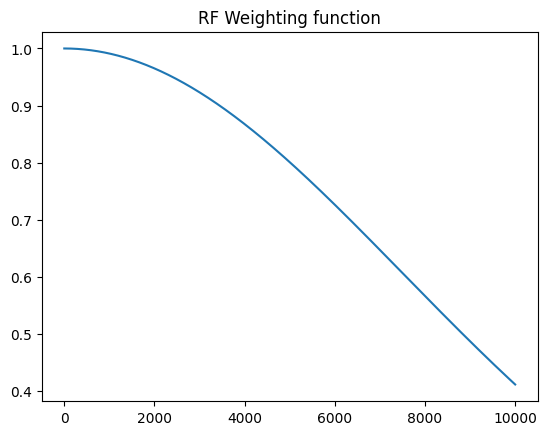

In [7]:
plt.figure()
plt.plot(D(b=2,a=1, A=3))
plt.title('RF Weighting function')
plt.xlabel = 't'

## define B1 ##

In [8]:
def B_1(W=np.ones((1,1000)), G_x=np.ones((1,1000)), G_y=np.ones((1,1000)),db=0):
    output = W * np.sqrt(G_x * G_x + G_y * G_y)
    if db:
        print('W=' + str(W.shape))
        print('G_x=' + str(G_x.shape))
        print('G_y=' + str(G_y.shape))
        print('B_1 output shape = ' + str(output.shape))
    return output

using nucleus ([Hz/T])42577478.517832555
using nucleus info (gamma [Hz/T])
using nucleus ([Hz/T])42577478.517832555
using nucleus info (gamma [Hz/T])
W=(10000,)
G_x=(10000,)
G_y=(10000,)
B_1 output shape = (10000,)


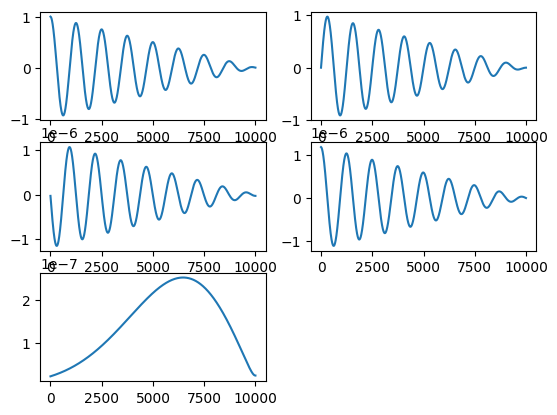

In [9]:
plt.figure()
plt.subplot(321)
plt.plot(k_x())
plt.subplot(322)
plt.plot(k_y())
plt.subplot(323)
plt.plot(G_x())
plt.subplot(324)
plt.plot(G_y())
plt.subplot(325)
plt.plot(B_1(W=D(b=2,k_x=k_x(),k_y=k_y()), G_x=G_x(), G_y=G_y(),db=1))
plt.title = 'B_1'
plt.xlabel = 't [a.u.]'

In [54]:
B0 = 1.5 # T 
nuc = '1h'; # protons
Fov = [24, 24] # cm
T = 8 * 1e-3 # s
dt = 0.0000001;
Gmax = 0.6 # G/cm
Gmax_T = 0.6 * 1e-4; # T/cm
n=4
Fov_res = [x / n /2 for x in Fov]
print(Fov_res)

[3.0, 3.0]


using nucleus ([Hz/T])42577478.517832555
using nucleus info (gamma [Hz/T])
using nucleus ([Hz/T])42577478.517832555
using nucleus info (gamma [Hz/T])
1/dk = FOV =(25.993750601185873+3.183316347157687e-15j)


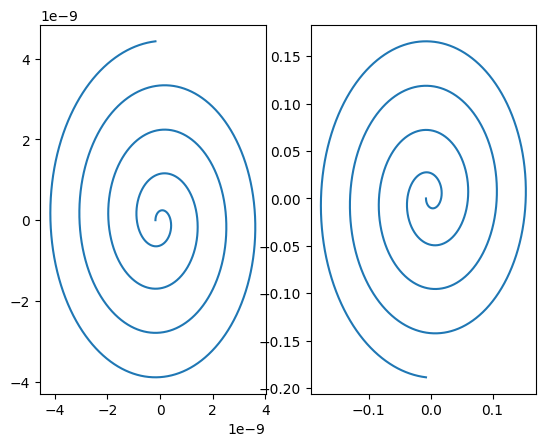

In [55]:
%matplotlib inline
gx= G_x(nuc='1h',A=Gmax_T, dt=dt,T=T,n=n)
gy= G_y(nuc='1h',A=Gmax_T, dt=dt,T=T,n=n)
kx= -42577478.517832555 * G_x(nuc='1h',A=Gmax_T, dt=dt,T=T,n=n) * np.exp(1j*np.pi) #np.cumsum(gx) 
ky= -42577478.517832555 * G_y(nuc='1h',A=Gmax_T, dt=dt,T=T,n=n) #* np.cumsum(gy) 



plt.figure()
plt.subplot(121);
plt.plot(gx,gy)
plt.title ='Gradients'
plt.subplot(122);
plt.plot(kx,ky)
plt.title = 'k-space'
print("1/dk = FOV =" + str(1/(2*max(kx)/2/n)))
# (A/gamma*T) * (2 * np.pi * n * (1 - t/T) * np.sin((2 * np.pi * n * t) / T) + np.cos((2 * np.pi * n * t) / T))

# [G/cm] / [Rad/s/T]

W=(80000,)
G_x=(80000,)
G_y=(80000,)
B_1 output shape = (80000,)
using nucleus ([Hz/T])42577478.517832555
using nucleus info (gamma [Hz/T])
W=(10000,)
G_x=(10000,)
G_y=(10000,)
B_1 output shape = (10000,)


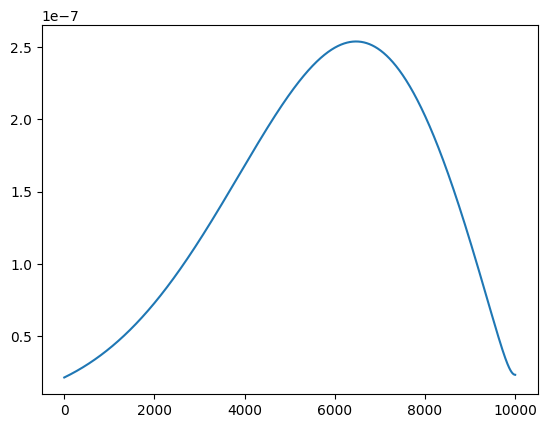

In [56]:
grads = {'gx' : gx, 'gy': gy}
b1 = B_1(W=D(b=2,k_x=kx,k_y=ky), G_x=gx, G_y=gy,db=1)
b1 = B_1(W=D(b=2,k_x=k_x(),k_y=k_y()), G_x=G_x(), G_y=G_y(),db=1)
plt.plot(np.abs(b1))
b1 = {'b1':b1}



In [57]:
sio.savemat('spiral_gradients_4.mat', grads)
sio.savemat('spiral_gradients_4_b1.mat', b1)